In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_mnist_config.json")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, data, ckpt_path="saved/models/Mnist_Ppc/0508_163004/checkpoint_9.ckpt")

Missing logger folder: saved/log/Mnist_Ppc/0508_163422/lightning_logs
/home/eli/miniforge3/envs/ppc/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/eli/AnacondaProjects/ppc_experiments/saved/models/Mnist_Ppc/0508_163422 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Mnist_Ppc/0508_163004/checkpoint_9.ckpt
/home/eli/miniforge3/envs/ppc/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/home/eli/AnacondaProjects/ppc_experiments/saved/models/Mnist_Ppc/0508_163004' to '/home/eli/AnacondaProjects/ppc_experiments/saved/models/Mnist_Ppc/0508_163422', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | 

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [6]:
model.graph.clear()
model.eval()
model.cpu()
model.particles['valid'].cpu()

ParticleDict(
    (z1): Parameter containing: [torch.FloatTensor of size 4x5000x20]
    (z2): Parameter containing: [torch.FloatTensor of size 4x5000x128]
    (z3): Parameter containing: [torch.FloatTensor of size 4x5000x256]
)

In [7]:
for site in model.graph.nodes:
    model.graph.nodes[site]['is_observed'] = model.graph.nodes[site]['value'] is not None

In [8]:
SEEDS = [123, 456, 789, 101112, 131415]

In [9]:
import utils

In [10]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [11]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for (xs, target, indices) in data.val_dataloader():
        model._load_particles(indices, False)
    
        predictive = pyro.condition(model.graph, data={k: v['value'] for k, v in model.graph.nodes.items() if k != 'X'})
        x_hats = predictive(xs=None, B=len(xs), P=model.num_particles, prior=True)
        x_hats = x_hats.mean(dim=0)
        LOG_LIKELIHOODS[s] += -torch.nn.functional.binary_cross_entropy(x_hats, xs, reduction="none").sum()
        MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean()

    LOG_LIKELIHOODS[s] /= len(data.val_dataloader().sampler)
    MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().sampler)

In [12]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-212.7477), tensor(0.0620))

In [13]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0612), tensor(2.0452e-05))

In [14]:
import matplotlib.pyplot as plt

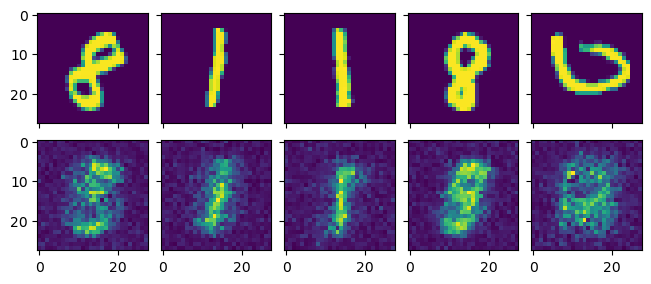

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for i in range(5):
    axes[0, i].imshow(xs[i].squeeze().detach().numpy())
    axes[1, i].imshow(x_hats[i].squeeze().detach().numpy())

fig.savefig("ppc_mnist_recons.pdf", bbox_inches="tight")
plt.show()

In [16]:
model.graph.clear()

In [17]:
x_hats = model.graph(B=len(xs), P=model.num_particles, prior=True)

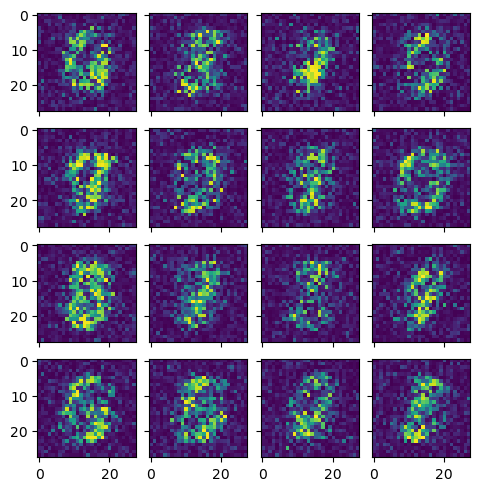

In [18]:
fig, axes = plt.subplots(nrows=model.num_particles, ncols=4, sharex="all", sharey="all", layout="compressed")

for i in range(model.num_particles):
    for j in range(4):
        axes[i, j].imshow(x_hats[i, j].squeeze().detach().numpy())

fig.savefig("ppc_mnist_samples.pdf", bbox_inches="tight")
plt.show()